[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Missing Values per Column:
id                         0
asins                      0
brand                      0
categories                 0
colors                   823
dateAdded                  0
dateUpdated                0
dimension               1032
ean                      699
keys                       0
manufacturer             632
manufacturerNumber       695
name                       0
prices                     0
reviews.date             380
reviews.doRecommend     1058
reviews.numHelpful       697
reviews.rating           420
reviews.sourceURLs         0
reviews.text               0
reviews.title             17
reviews.userCity        1597
reviews.userProvince    1597
reviews.username          17
sizes                   1597
upc                      699
weight                   911
dtype: int64


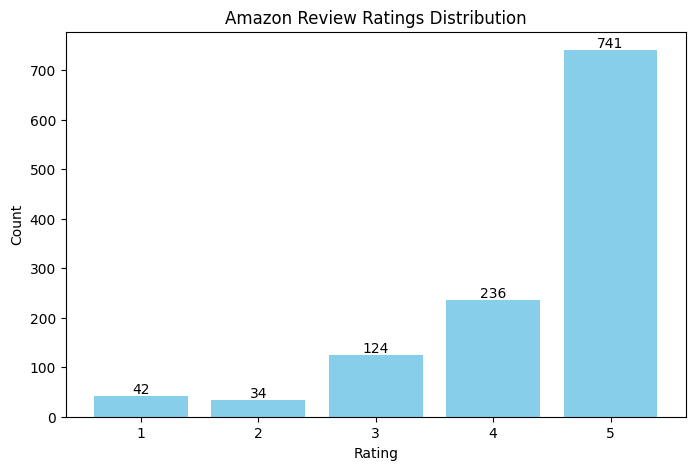

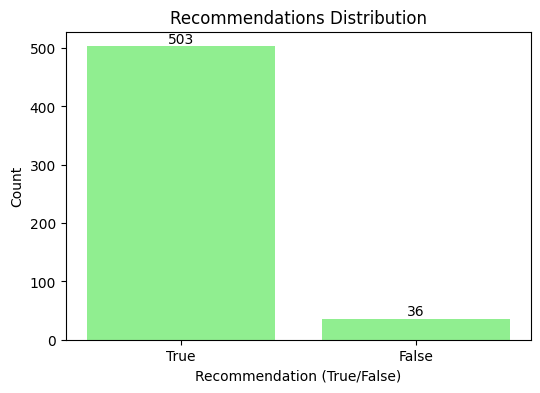

Top 5 Organizations Mentioned:
 Amazon    1108
Apple      370
HDX        338
iPad       290
Alexa      242
Name: count, dtype: int64

Organization: Amazon
Positive Reviews: 664
Negative Reviews: 25
Neutral Reviews: 4

Organization: Apple
Positive Reviews: 256
Negative Reviews: 0
Neutral Reviews: 0

Organization: HDX
Positive Reviews: 170
Negative Reviews: 0
Neutral Reviews: 0

Organization: iPad
Positive Reviews: 168
Negative Reviews: 0
Neutral Reviews: 0

Organization: Alexa
Positive Reviews: 176
Negative Reviews: 7
Neutral Reviews: 3


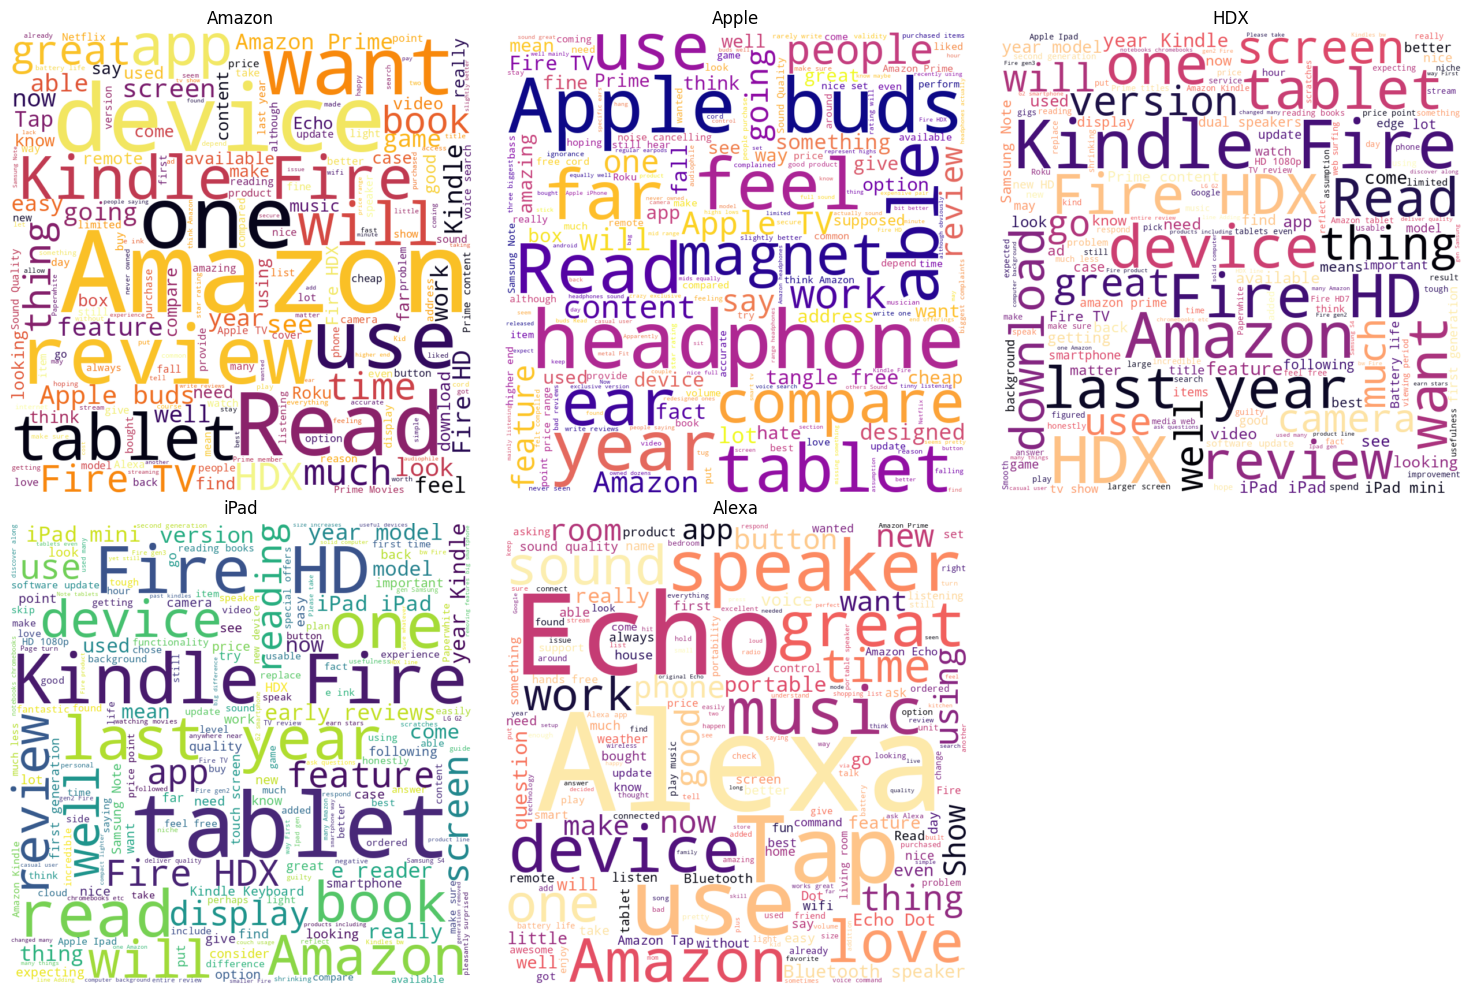

In [1]:
# ----------------------------
# Amazon Review Sentiment & Organization Analysis
# ----------------------------

import pandas as pd
import matplotlib.pyplot as plt
import spacy
from textblob import TextBlob
import nltk
from wordcloud import WordCloud
import random

# Download nltk resources
nltk.download('punkt')
nltk.download('wordnet')

# 1️⃣ Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/amazon_reviews.csv')

# 2️⃣ Check for missing values
print("Missing Values per Column:")
print(df.isnull().sum())

# Drop rows with missing review text
df.dropna(subset=['reviews.text'], inplace=True)

# 3️⃣ Visualize Ratings
if 'reviews.rating' in df.columns:
    rating_counts = df['reviews.rating'].value_counts().sort_index()
    plt.figure(figsize=(8,5))
    plt.bar(rating_counts.index, rating_counts.values, color='skyblue')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title('Amazon Review Ratings Distribution')
    plt.xticks(rating_counts.index)
    for i, count in enumerate(rating_counts.values):
        plt.text(rating_counts.index[i], count, str(count), ha='center', va='bottom')
    plt.show()

# 4️⃣ Visualize Recommendations (if available)
if 'reviews.doRecommend' in df.columns:
    recommend_counts = df['reviews.doRecommend'].value_counts()
    plt.figure(figsize=(6,4))
    plt.bar(recommend_counts.index.astype(str), recommend_counts.values, color='lightgreen')
    plt.xlabel('Recommendation (True/False)')
    plt.ylabel('Count')
    plt.title('Recommendations Distribution')
    for i, count in enumerate(recommend_counts.values):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.show()

# 5️⃣ Load SpaCy for NER
nlp = spacy.load("en_core_web_sm")

def perform_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply NER on reviews
df['ner_entities'] = df['reviews.text'].apply(perform_ner)

# Extract ORG entities
org_entities = df['ner_entities'].explode()
org_entities = org_entities[org_entities.notnull()]
org_only = [ent[0] for ent in org_entities if ent[1] == 'ORG']

# Top 5 most mentioned organizations
top_5_orgs = pd.Series(org_only).value_counts().head(5)
print("Top 5 Organizations Mentioned:\n", top_5_orgs)

# 6️⃣ Sentiment analysis functions
def classify_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

def count_sentiments(reviews_series):
    sentiments = reviews_series.apply(lambda text: classify_sentiment(TextBlob(str(text)).sentiment.polarity))
    return sentiments.value_counts()

# Sentiment counts per top organization
sentiment_counts_by_org = {}
for org in top_5_orgs.index:
    org_reviews = df[df['reviews.text'].str.contains(org, case=False, na=False)]['reviews.text']
    sentiment_counts_by_org[org] = count_sentiments(org_reviews)

# Print sentiment summary
for org, counts in sentiment_counts_by_org.items():
    print(f"\nOrganization: {org}")
    print(f"Positive Reviews: {counts.get('positive', 0)}")
    print(f"Negative Reviews: {counts.get('negative', 0)}")
    print(f"Neutral Reviews: {counts.get('neutral', 0)}")

# 7️⃣ WordClouds for top organizations
top_words = {}
for org in top_5_orgs.index:
    org_reviews = df[df['reviews.text'].str.contains(org, case=False, na=False)]['reviews.text']
    top_words[org] = ' '.join(org_reviews)

plt.figure(figsize=(15,10))
for i, (org, words) in enumerate(top_words.items(), 1):
    wordcloud = WordCloud(width=800, height=800, background_color='white',
                          min_font_size=10, colormap=random.choice(['viridis', 'plasma', 'inferno', 'magma'])).generate(words)
    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(org)
    plt.axis("off")

plt.tight_layout()
plt.show()
